### Set GPU

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

### Set Dataset Name

In [2]:
# dataset_name = 'CIFAR10'
# dataset_name = 'CIFAR100'
# dataset_name = 'MNIST'
# dataset_name = 'TINYIMAGENET'
dataset_name = 'IMBALANCED_CIFAR10'

### Run All

In [3]:
import numpy as np
import torch
from tqdm import tqdm

from models.resnet_cifar import resnet18
from utils.config import create_config
from utils.common_config import get_model

In [4]:
output_folder = '../results/'
if dataset_name == "CIFAR10":
    output_folder += 'cifar-10/'
    config_exp_path = './configs/pretext/simclr_cifar10.yml'
    cfg_path = 'configs/CIFAR10_RESNET18.yaml'
elif dataset_name == "CIFAR100":
    output_folder += 'cifar-20/'
    config_exp_path = './configs/pretext/simclr_cifar20.yml'
    cfg_path = 'configs/CIFAR100_RESNET18.yaml'
elif dataset_name == "MNIST":
    output_folder += 'mnist/'
    config_exp_path = './configs/pretext/simclr_mnist.yml'
    cfg_path = 'configs/MNIST_RESNET18.yaml'
elif dataset_name == "TINYIMAGENET":
    output_folder += 'tinyimagenet/'
    config_exp_path = './configs/pretext/simclr_tinyimagenet.yml'
    cfg_path = 'configs/TINYIMAGENET_RESNET18.yaml'
elif dataset_name == 'IMBALANCED_CIFAR10':
    output_folder += 'imbalanced-cifar-10/'
    config_exp_path = './configs/pretext/simclr_cifar10_im.yml'
    cfg_path = 'configs/CIFAR10_RESNET18.yaml'
    
path_to_model = output_folder + 'pretext/model.pth.tar'

temp = torch.load(path_to_model)

In [5]:
import argparse

config_env_path = './configs/env.yml'
p = create_config(config_env_path, config_exp_path)

In [6]:
model = get_model(p)
model.load_state_dict(temp)
model.eval()
model.cuda();

### Creating a SimCLR Augmentation Dataset

In [7]:
# Owner of this file: Thalles Silva
# Source: https://github.com/sthalles/PyTorch-BYOL
import torch
from torchvision import transforms
import torch.nn as nn
import numpy as np


class GaussianBlur(object):
    """Blurs a single image on CPU"""

    def __init__(self, kernel_size):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.blur_h = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1),
                                stride=1, padding=0, bias=False, groups=3)
        self.blur_v = nn.Conv2d(3, 3, kernel_size=(1, kernel_size),
                                stride=1, padding=0, bias=False, groups=3)
        self.k = kernel_size
        self.r = radias

        self.blur = nn.Sequential(
            nn.ReflectionPad2d(radias),
            self.blur_h,
            self.blur_v
        )

        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)

        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)

        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))

        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()

        img = self.tensor_to_pil(img)

        return img

In [8]:
def gaussian_blur(im, input_shape):
    """Applies GaussianBlur to input image."""
    blur = GaussianBlur(kernel_size=int(0.1 * input_shape))
    if dataset_name == 'MNIST':
        return Image.fromarray(np.uint8(im)).filter(ImageFilter.GaussianBlur(radius = 3)).convert("L")
    return Image.fromarray(np.uint8(blur(im))).convert("RGB")


def horizontal_flip(im):
    """Performs horizontal flip."""
    if dataset_name == 'MNIST':
        return Image.fromarray(np.uint8(im)).transpose(PIL.Image.FLIP_LEFT_RIGHT).convert("L")
    return Image.fromarray(np.uint8(im[:, ::-1, :])).convert("RGB")

def color_jitter(im):
    """Performs Color Jitter based on SimCLR paper."""
    s=1
    im = Image.fromarray(np.uint8(im)).convert("RGB")
    color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    out = Image.fromarray(np.uint8(color_jitter(im)))
    if dataset_name == 'MNIST':
        return out.convert("L")
    return out.convert("RGB")

def gray_scale(im):
    """Converts the input image into a grayscale image."""
    gray = transforms.RandomGrayscale(p=1)
    im = Image.fromarray(np.uint8(im)).convert("RGB")
    if dataset_name == 'MNIST':
        return im.convert("L")
    return im.convert("L").convert("RGB")

In [15]:
import torch
import numpy as np
from typing import Any, Tuple
from PIL import Image, ImageFilter 
import PIL
import torchvision


class SimCLRAugmentedDataset(torch.utils.data.Dataset):
    """
    Gives a dataset with all SimCLR Augmentations for each image. 
    
    Args:
        name (string): Name of the dataset. E.g., 'CIFAR10', 'TINYIMAGENET', etc.
        dataset (Dataset, optional): PyTorch Dataset object. 
        
    """
    def __init__(self, name, dataset):
        super(SimCLRAugmentedDataset, self).__init__()
        self.name = name
        self.dataset = dataset
        if self.name in ['CIFAR10', 'CIFAR100', 'MNIST', 'SVHN', 'IMBALANCED_CIFAR10', 'IMBALANCED_CIFAR100']:
            self.old_samples = self.dataset.data
            self.labels = []
        else: # Tiny ImageNet
            self.old_samples = [item[0] for item in self.dataset.samples]
            self.old_samples = [np.asarray(Image.open(img).convert("L")) for img in self.old_samples]
        self.data, self.targets = self.create_augmentations()
        self.transform = self.dataset.transform
        
    def create_augmentations(self):
        imgs, labels = [], []
        for idx in tqdm(range(len(self.old_samples)), desc="Creating Augmented Dataset"):
            img = self.old_samples[idx]
            augmented_imgs = [
                torchvision.transforms.ToPILImage()(img),
                horizontal_flip(img),
                gaussian_blur(img, img.shape[0]),
                color_jitter(img),
                gray_scale(img)
            ]
            augmented_labels = torch.LongTensor([self.dataset.targets[idx] for x in range(5)])
            if self.name == 'MNIST':
                imgs.extend(augmented_imgs[:-1])
                labels.extend(augmented_labels[:-1])
            else:
                imgs.extend(augmented_imgs)
                labels.extend(augmented_labels)
        return imgs, labels
    
    def __len__(self):
        return len(self.targets)
    
    def __repr__(self) -> str:
        head = "SimCLR Augmentated Dataset of " + self.name 
        body = ["Augmentations: GaussianBlur, ColorJitter, HorizontalFlip, GrayScale."]
        body += ["Number of datapoints (5 x original dataset): {}".format(self.__len__())]
        body += ["Normalization Values:"]
        if self.transform is not None:
            body += [repr(self.transform)]
        lines = [head] + [" " + line for line in body]
        return '\n'.join(lines)
    
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
#         print(img.shape)
#         print(type(img))
#         img = torchvision.transforms.ToPILImage()(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [16]:
from pycls.datasets.data import Data
from pycls.config import cfg


cfg.merge_from_file(cfg_path)
cfg.DATASET.NAME = dataset_name
data_obj = Data(cfg)
data_obj.eval_mode = True
train_data, train_size = data_obj.getDataset(save_dir=f'../{cfg.DATASET.ROOT_DIR}', isTrain=True, isDownload=True)
simclr_data = SimCLRAugmentedDataset(dataset_name, train_data)

Files already downloaded and verified


Creating Augmented Dataset:   0%|          | 29/13996 [00:00<00:49, 281.03it/s]

Train Mode: Contain 13996 images


Creating Augmented Dataset: 100%|██████████| 13996/13996 [00:36<00:00, 383.30it/s]


In [17]:
simclr_data

SimCLR Augmentated Dataset of IMBALANCED_CIFAR10
 Augmentations: GaussianBlur, ColorJitter, HorizontalFlip, GrayScale.
 Number of datapoints (5 x original dataset): 69980
 Normalization Values:
 Compose(
    RandomCrop(size=(32, 32), padding=4)
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
)

### DO NOT Change Batch Size

In [18]:
if dataset_name == 'MNIST':
    batch_size = 4
else:
    batch_size = 5

In [19]:
trainSet = [i for i in range(len(simclr_data))]
trainSet = np.array(trainSet, dtype=np.ndarray)
train_dataloader = data_obj.getSequentialDataLoader(indexes=trainSet, batch_size=5, data=simclr_data)

### SimCLR Augmentations Examples

In [20]:
import matplotlib.pyplot as plt


def imshow(img):
    plt.figure(figsize=(10,3))
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.xticks([])
    plt.yticks([])
    plt.savefig('SimCLR_Loss_Example.png')
    plt.show()
    
dataiter = iter(train_dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


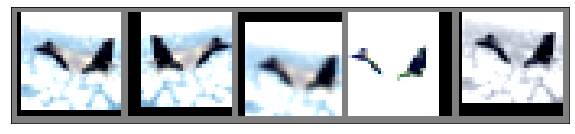

tensor([0, 0, 0, 0, 0])


In [24]:
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(labels)

### Calculating SimCLRLoss between image and its augmented variants

In [25]:
from losses.losses import SimCLRLoss

image_losses = []
for images, lbl in tqdm(train_dataloader, desc="Calculating SimCLR Loss: "):
    b, c, h, w = images.size()
    criterion = SimCLRLoss(temperature=0.1)
    all_losses = []
    with torch.no_grad():
        for idx in range(1, b):
            input_ = torch.cat([images[0],images[idx]])
            input_ = input_.view(-1, c, h, w) 
            input_ = input_.cuda(non_blocking=True)
            output = model(input_).view(1, 2, -1)
            loss = criterion(output)
            all_losses.append(loss.item())
        image_losses.append(np.mean(all_losses))

Calculating SimCLR Loss: 100%|██████████| 13996/13996 [03:37<00:00, 64.44it/s]


In [26]:
image_losses=np.array(image_losses)

In [27]:
np.save(f'{output_folder}/{dataset_name}_SimCLR_losses.npy', image_losses)